# Channel with varying width



We study a connection between two ballistic channels with different widths.

In [67]:
# this is necessary if using a module with external functions, in this case if file will be modified, functions will reload.
%load_ext autoreload
%autoreload 2


import numpy as np
import kwant
%run matplotlib_setup.ipy
import matplotlib
from matplotlib import pyplot as plt
import aux_funcs
from types import SimpleNamespace
from kwant.digest import uniform    # a (deterministic) pseudorandom number generator
from types import SimpleNamespace
import copy
from cmath import exp

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
lat = kwant.lattice.square(norbs=1)

In [3]:
def make_wire_var(W1=10, W2=20, L1=5, L2=5, t=1):
    def on_edge(site, params):
        return  params.Uw * (uniform(repr(site), repr(params.salt)) - 0.5) + 4 * t

    def hopping(site_i, site_j, params):
        xi, yi = site_i.pos
        xj, yj = site_j.pos  
        return -t*exp(-0.5j * params.phi * (xi - xj) * (yi + yj))
    
    # Construct the scattering region.
    sr = kwant.Builder()
    sr[(lat(x, y) for x in range(L1) for y in range(W1))] = 4 * t
    sr[(lat(x, y) for x in range(L1, L1+L2+1) for y in range(W2))] = 4 * t
    sr[lat.neighbors()] = hopping
    
    # make walls rough
    for site in aux_funcs.edges(sr, lat):
        sr[site] = on_edge
        
    
    # Build and attach lead from both sides.
    lead_l = kwant.Builder(kwant.TranslationalSymmetry([-1,0]))
    lead_l[(lat(0,y) for y in range(W1))] = 4*t
    lead_l[lat.neighbors()] = hopping
    
    lead_r = kwant.Builder(kwant.TranslationalSymmetry([1,0]))
    lead_r[(lat(0,y) for y in range(W2))] = 4*t
    lead_r[lat.neighbors()] = hopping
    
    sr.attach_lead(lead_l)
    sr.attach_lead(lead_r)

    return sr.finalized()

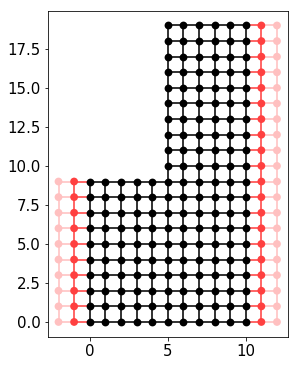

In [4]:
kwant.plot(make_wire_var());

In [5]:
def plot_transmission_p(syst, energy, params):
    # Compute conductance
    trans = []
    for param in params:
        smatrix = kwant.smatrix(syst, energy, args=[param])
        trans.append(smatrix.transmission(1, 0))
    pyplot.plot(params, trans)
    
def plot_transmission_e(syst, energies, param):
    # Compute conductance
    trans = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy, args=[param])
        trans.append(smatrix.transmission(1, 0))
    pyplot.plot(energies, trans, '+')

## Transmission as a function of energy - small number of modes

what happens when we can resolve transmission of individual subbands? Let's say we have a channel with uniform width W=10:

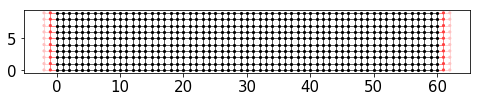

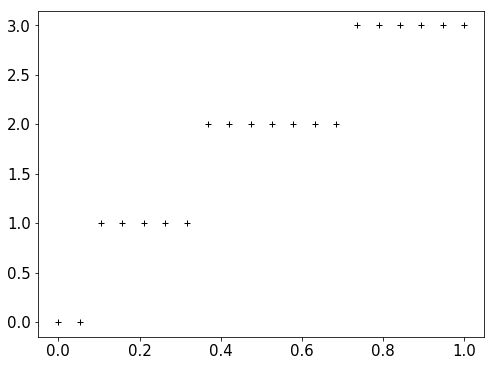

In [6]:
W=10
L=30
_sys_uniform = make_wire_var(W1=W, W2=W, L1=L, L2=L)
kwant.plot(_sys_uniform);
params = SimpleNamespace(phi=0, salt=14, Uw=0)
es = np.linspace(0,1,20)
plot_transmission_e(_sys_uniform, es, params)

now what happens when we make a varying width channel? It looks almost the same.

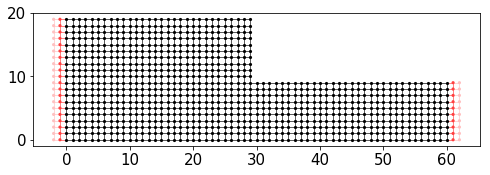

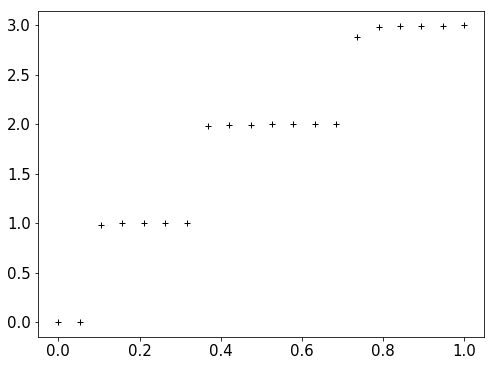

In [16]:

L=30
_sys_small = make_wire_var(W1=20, W2=10, L1=L, L2=L)
kwant.plot(_sys_small);
params = SimpleNamespace(phi=0, salt=14, Uw=0)
es = np.linspace(0,1,20)
plot_transmission_e(_sys_small, es, params)

## Large system

Now let's abandon the few-mode approximation. What is the shape of the wavefunction?

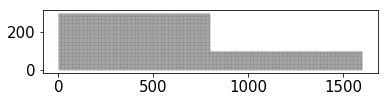

In [58]:
params = SimpleNamespace(phi=0, salt=14, Uw=0)
_sys = make_wire_var(W1=300, L1= 800, L2 = 800, W2=100)
kwant.plot(_sys);
es = np.linspace(0,1,20)
#plot_transmission_e(_sys, es, params)

we can see that we have a very fine subband structure:

In [53]:
def calc_wavefunction(syst, energy, lead, Uw, phi, modes='all'):
    params = SimpleNamespace(Uw=Uw, phi=phi, salt=12);
    wfs = kwant.wave_function(syst, energy, args=[params])
    if modes=='all':
        density = np.sum(abs(wfs(lead))**2, axis=0)
    else:
        density = abs(wfs(lead)[modes])**2
    return density



## current from right lead

Let's look at the density when injecting a current from the right lead at energy $E=0.2t$. What is the density drop?

Intuitively we expect the ratios of densities to be on the order of the ratios of the widths. The reason is that there is current conservation, so $I=W_1 n_1 v = W_2 n_2 v$. The velocities are the approximately the same because the energy as well as $k_y$ are conserved (or nearly conserved in the case of $k_y$, as we will soon show).

In [59]:
wf_right1 = calc_wavefunction(_sys, 0.2, 1, 0, 0)

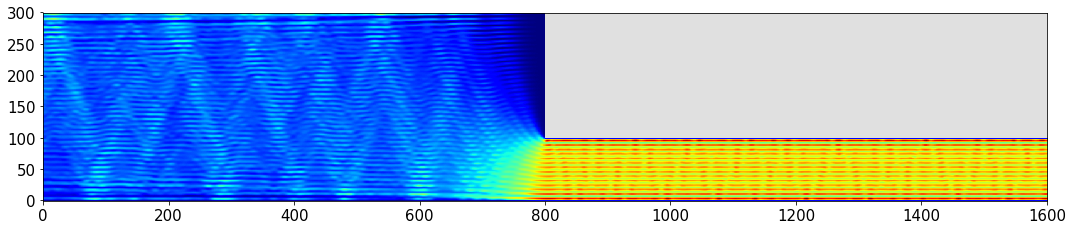

In [60]:
fig_right1 = kwant.plotter.map(_sys, wf_right1, cmap = pyplot.get_cmap('jet'), colorbar = False, fig_size=(18,8));

## plot linecuts

### x-axis linecuts for different widths

In [125]:
def plot_density_linecuts_widths():
    plt.figure(figsize=(10,10))
    widths = [100, 150, 200, 250, 300]
    params = SimpleNamespace(phi=0, salt=14, Uw=0)
    
    cuts = []
    colors = ['b','g','r','c','m']
    for c, width in zip(colors, widths):
        #print(width)
        sys = make_wire_var(W1=width, L1= 800, L2 = 800, W2=100)
        wf_right = calc_wavefunction(sys, 0.2, 1, 0, 0)
        cut = aux_funcs.linecut_at_dim(sys, lat, wf_right, 0, 5)
        cuts.append(cut)
        pyplot.plot(cut['positions'], cut['wavefunc'], color=c)
        #pyplot.plot(cut['positions'], 0.5*cut['wavefunc'][-1]*np.ones((1,len(cut['positions']))), '+', color=c)

        
    plt.xlabel('x'); plt.ylabel('density'); plt.title('density at y=50, E=0.2t')
    plt.legend(['W = '+str(width) for width in widths])
    plt.show()
    
    


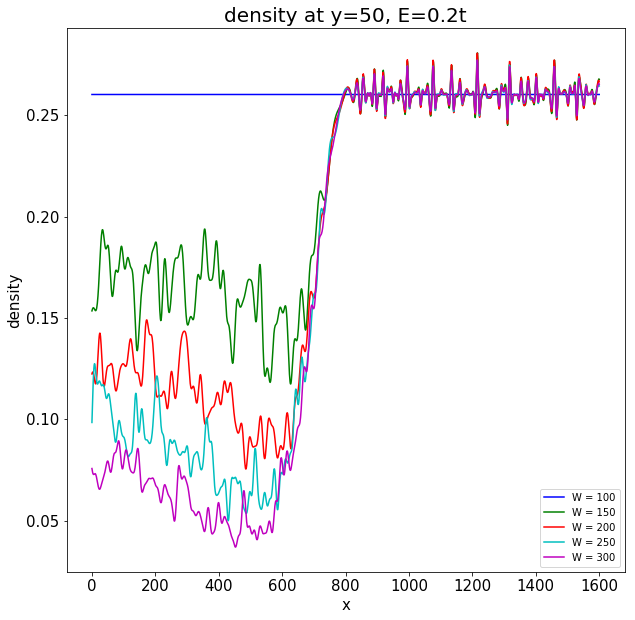

In [126]:
plot_density_linecuts_widths()

## Resolving individual modes

To get a better insight let's look at the density of individual modes. Here we will understand why the profile looks the way it does.

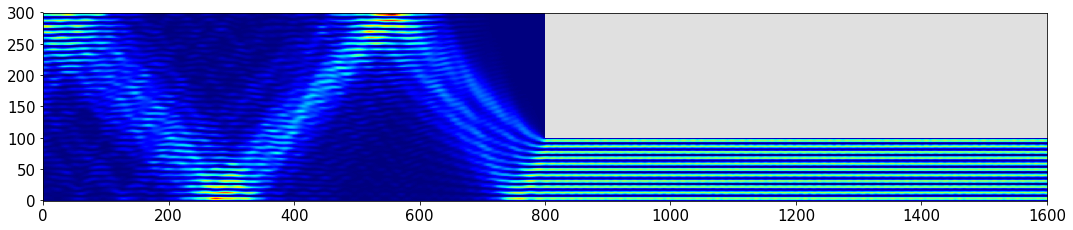

In [77]:
wf10=calc_wavefunction(_sys, 0.2, 1, 0, 0, modes=10)
plt10=kwant.plotter.map(_sys, wf10, cmap = pyplot.get_cmap('jet'), colorbar = False, fig_size=(18,8));

We can see that there is a "zig-zag" pattern in the wide lead. Is this also true for other modes? The answer is yes:

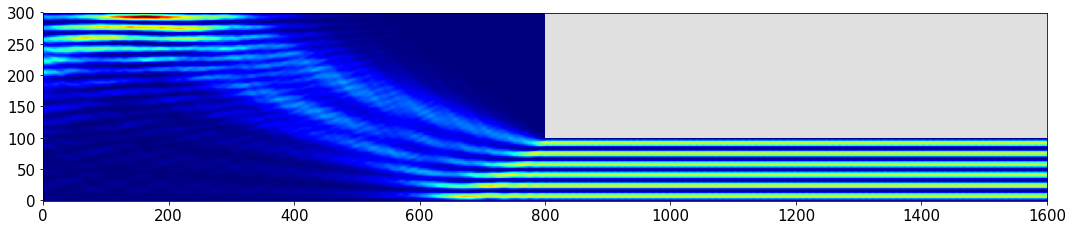

In [78]:
wf5 = calc_wavefunction(_sys, 0.2, 1, 0, 0, modes=5)
kwant.plotter.map(_sys, wf5, cmap = pyplot.get_cmap('jet'), colorbar = False, fig_size=(18,8));

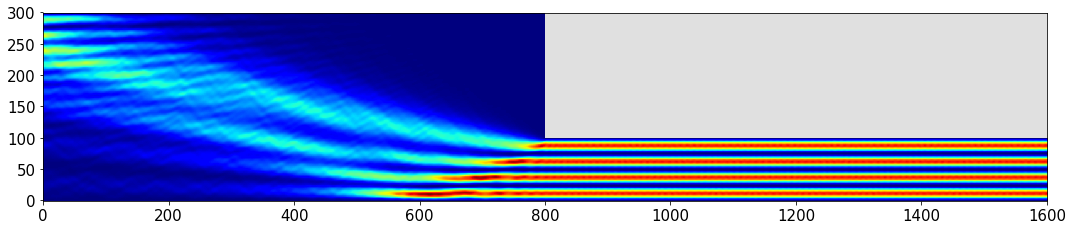

In [79]:
wf3 = calc_wavefunction(_sys, 0.2, 1, 0, 0, modes=3)
kwant.plotter.map(_sys, wf3, cmap = pyplot.get_cmap('jet'), colorbar = False, fig_size=(18,8));

where is this zig-zag pattern coming from? It's simple if thinking about the corresponding billiard-ball trajectories. In the narrow channel, the particle has a well defined $k_y$ component, with equal probability of being in $\pm k_y$. That value of $k_y$ is maintained when switching to the large width channel because of momentum conservation, however the state immediately after the transition only occupies some of the channel. Then it moves to the $+y$ direction exactly as a billiard ball that has the same y-momentum component would do. In fact, up to the nodes, this mirrors a statistical distribution of billiard balls emitted from a contact with well-defined y-momenta, up to sign.

In [147]:
trans = smat.transmission(0,1)
trans

13.983200801964983

In [141]:
smat.num_propagating(1)

14

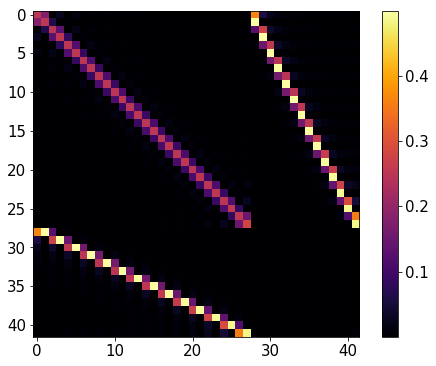

In [142]:
pyplot.imshow(abs(smat.data)**2)
pyplot.colorbar()

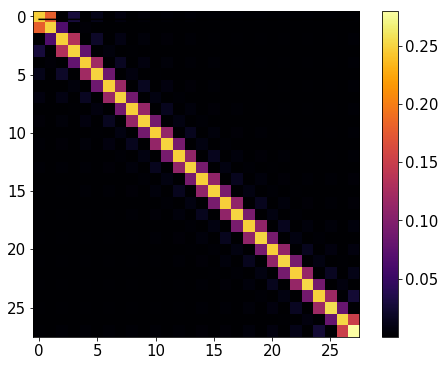

In [191]:
wide_channel_s = abs(smat.data[smat.block_coords(0,0)])**2
pyplot.plot(wide_channel_s.diagonal(0))
ims=pyplot.imshow(abs(smat.data[smat.block_coords(0,0)])**2)
pyplot.colorbar()

5.21829894459


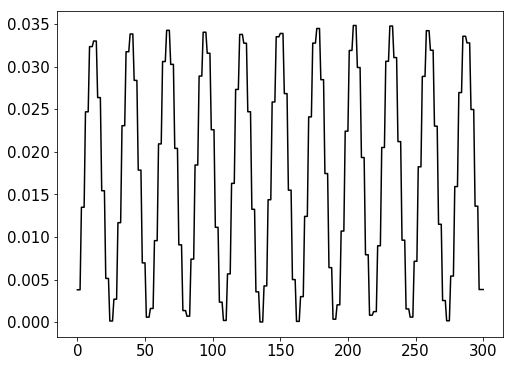

In [209]:
im=ims.axes.get_children()[-2]
im.get_array().shape

(28, 28)

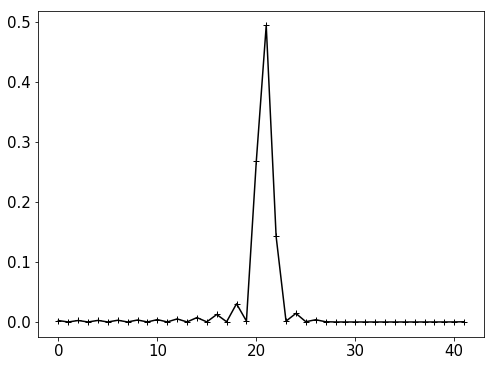

In [146]:
pyplot.plot(abs(smat.data[10+28,:])**2, '+-')

-0.573765274775
-0.569927885676


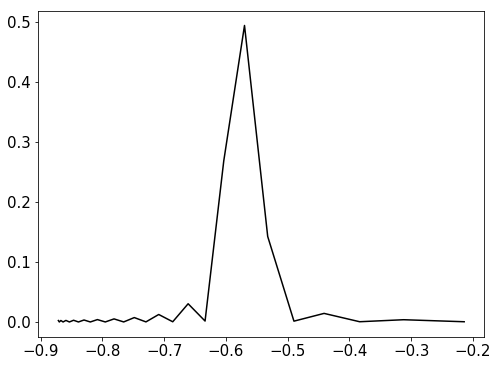

In [190]:
yy=abs(smat.submatrix(1,0)[10,:])**2
pm = smat.lead_info[0]
xx=pm.velocities[0:28]
print(smat.lead_info[1].velocities[10])
pyplot.plot(xx,yy)
print(xx[yy.argmax()])

In [ ]:
yy=abs(smat.submatrix(1,0)[10,:])**2
pm = smat.lead_info[0]
xx=pm.velocities[0:28]
pyplot.plot(xx,yy)


## current with finite bias

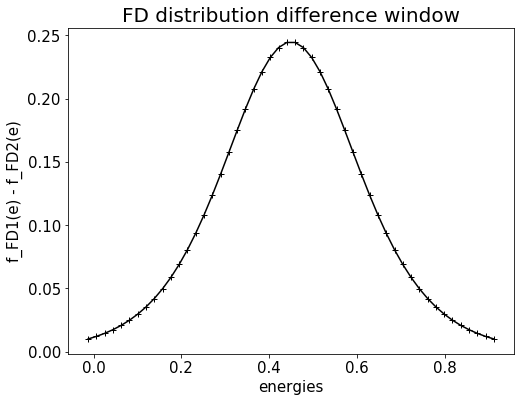

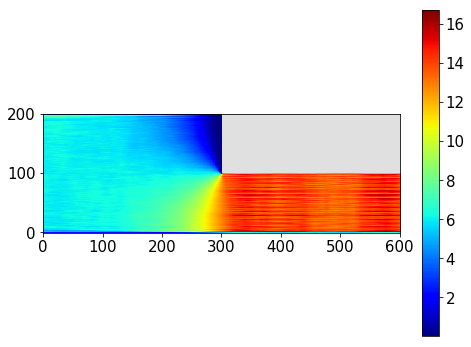

In [18]:
wf = wavefunc_finite_bias(_sys, params, 0.5, 0.4, 0.1, 0.1, 1, cutoff = 1e-2, Ngrid = 50, verbose = True)
kwant.plotter.map(_sys, wf, cmap = pyplot.get_cmap('jet'));

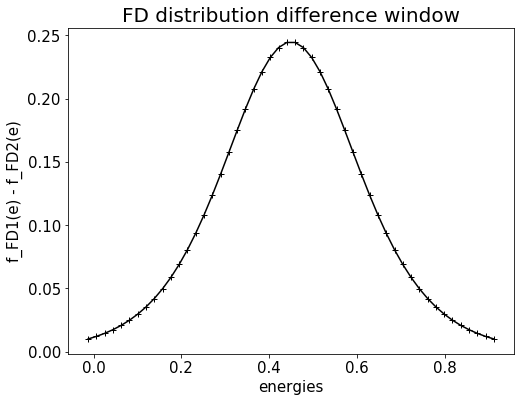

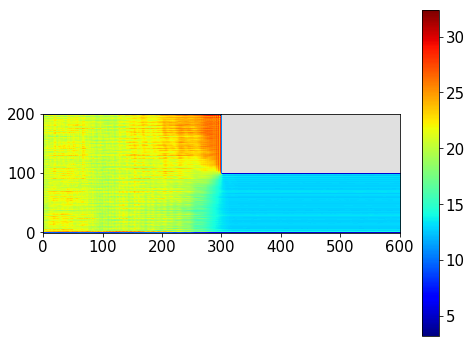

In [19]:
wf = wavefunc_finite_bias(_sys, params, 0.5, 0.4, 0.1, 0.1, 0, cutoff = 1e-2, Ngrid = 50, verbose = True)
kwant.plotter.map(_sys, wf, cmap = pyplot.get_cmap('jet'));

In [30]:
current = kwant.operator.Current(_sys_uniform)